In [1]:
#If this is your first run, Please run svd_database_init.py before running this file!

import warnings
warnings.filterwarnings('ignore')

In [2]:
from fastaudio.augment.all import *
from fastaudio.core.all import *
from fastai.vision.all import *
from fastaudio.ci import skip_if_ci
from fastai.callback.fp16 import *
import pandas as pd
set_seed(12)

In [3]:
df = pd.read_csv('../data/svd_speech/voice_samples/all/dataset.csv')
df.head(10)

,filename,sex,fold,target
0,1285-phrase.wav,1,0,pathology
1,1369-phrase.wav,0,1,healthy
2,121-phrase.wav,0,0,healthy
3,1967-phrase.wav,1,1,pathology
4,2388-phrase.wav,0,1,pathology
5,2146-phrase.wav,1,0,pathology
6,2033-phrase.wav,0,0,pathology
7,1760-phrase.wav,0,1,pathology
8,725-phrase.wav,0,0,pathology
9,2391-phrase.wav,0,0,pathology


In [4]:
df.value_counts(['target', 'sex'], normalize=True)

target     sex
pathology  0      0.365191
           1      0.315895
healthy    0      0.192153
           1      0.126761
dtype: float64

In [5]:
df.value_counts(['target'], normalize=True)

target   
pathology    0.681087
healthy      0.318913
dtype: float64

In [6]:
def CrossValidationSplitter(col='fold', fold=1):
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [7]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [8]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),  
                 get_x = ColReader("filename", pref="../data/svd_speech/voice_samples/all/"), 
                 splitter = CrossValidationSplitter(fold=1),
                 item_tfms=[ResizeSignal(1500)],
                 batch_tfms = [a2s],
                 get_y = ColReader("target"))

In [9]:
dbunch = auds.dataloaders(df, bs=64, seed=12)

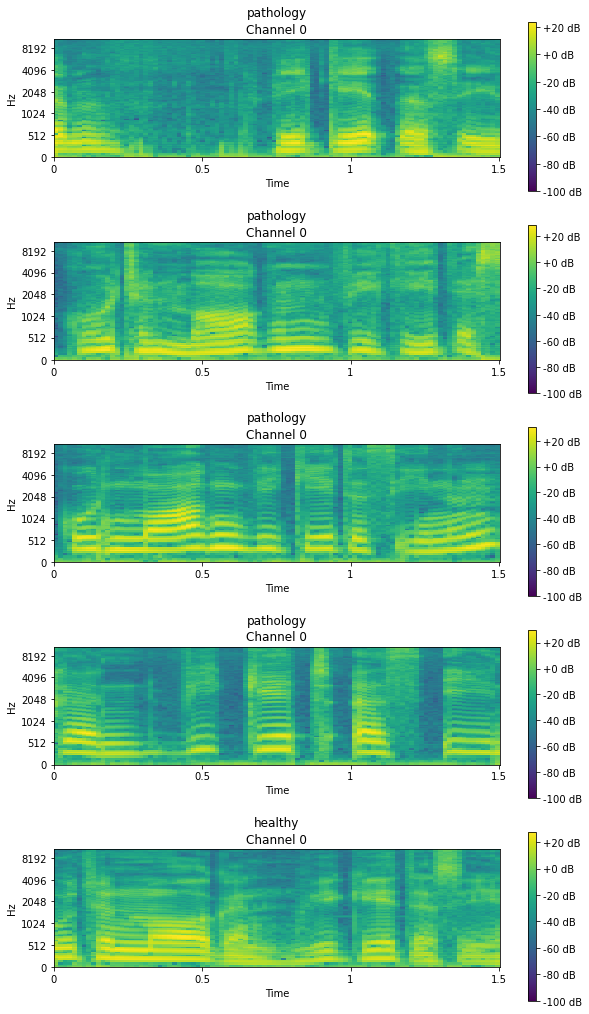

In [10]:
dbunch.show_batch(nrows=5, figsize=(10, 18))

In [11]:
learn = cnn_learner(dbunch, 
            resnet18,
            n_in=1,
            loss_func=CrossEntropyLossFlat(), 
            metrics=[accuracy]).to_fp16()

In [12]:
learn.fine_tune(9, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.272177,0.864444,0.532533,00:02
1,1.181681,0.822293,0.633634,00:01
2,1.045930,0.774011,0.651652,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.791149,0.720407,0.675676,00:02
1,0.774149,0.664327,0.700701,00:02
2,0.731296,0.629031,0.719720,00:02
3,0.674953,0.644604,0.731732,00:02
4,0.628951,0.574345,0.741742,00:02
5,0.579064,0.550260,0.752753,00:02
6,0.529810,0.556490,0.759760,00:02
7,0.480763,0.549159,0.770771,00:02
8,0.454302,0.546635,0.758759,00:02
